# Lab04-1: Perceptron, Adaline, and Optimization
<hr>

110062802 呂宸漢


Implement the Adaline with SGD which can set different batch_size ($M$) as parameter. Then, use the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset to fit your model with 3 different $M$ (including $M=1$) and fixed learning rate $\eta$ and print out the accuracy of each model. Last, plot the cost against the number of epochs using different $M$ in one figure.


## 1. Data Preprocessing


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [-1  1]


## 2. Build Adaline with SGD and Mutable Batch Size


In [2]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    batch_size : int
        Batch size for SGD

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.

    """

    def __init__(self, eta=0.01, n_iter=50, batch_size=1, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.shuffle = shuffle
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost_sum = 0
            for i in range(X.shape[0] // self.batch_size):
                begin = i * self.batch_size
                end = begin + self.batch_size
                cost_sum += self._update_weights(X[begin:end], y[begin:end])
            self.cost_.append(cost_sum / len(y))
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)

    def _update_weights(self, Xb, yb):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(Xb)

        # Cost function
        error = (yb - output)
        cost = 0.5 * np.sum(error ** 2)

        # Update rule
        self.w_[1:] += self.eta * Xb.T.dot(error)
        self.w_[0] += self.eta * error.sum()

        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)


## 3. Evaluate Adaline with Different Batch Size


In [3]:
from sklearn.metrics import accuracy_score


def evaluate_adalineSGD(batch_size):
    adas = AdalineSGD(n_iter=20, eta=0.01, batch_size=batch_size, random_state=1)
    adas.fit(X_train_std, y_train)

    y_pred = adas.predict(X_test_std)
    print(f'Evaluate AdalineSGD with batch_size={batch_size}')
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))
    return adas


Evaluate AdalineSGD with batch_size=1
Misclassified samples: 3
Accuracy: 0.85

Evaluate AdalineSGD with batch_size=40
Misclassified samples: 3
Accuracy: 0.85

Evaluate AdalineSGD with batch_size=80
Misclassified samples: 3
Accuracy: 0.85



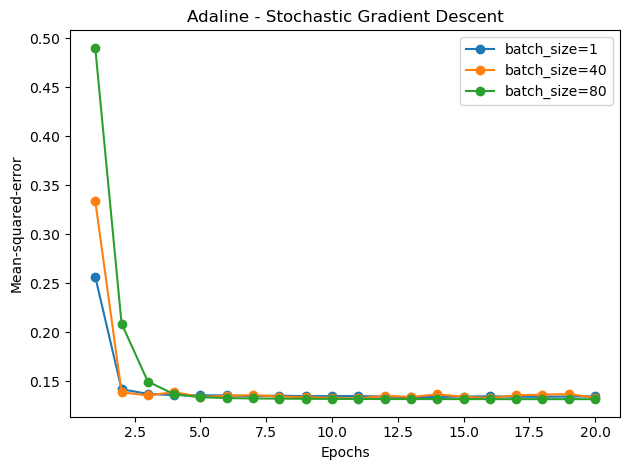

In [4]:
import matplotlib.pyplot as plt

adas1 = evaluate_adalineSGD(batch_size=1)
adas2 = evaluate_adalineSGD(batch_size=40)
adas3 = evaluate_adalineSGD(batch_size=80)

plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_,
         marker='o', label=f'batch_size={adas1.batch_size}')
plt.plot(range(1, len(adas2.cost_) + 1), adas2.cost_,
         marker='o', label=f'batch_size={adas2.batch_size}')
plt.plot(range(1, len(adas3.cost_) + 1), adas3.cost_,
         marker='o', label=f'batch_size={adas3.batch_size}')
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Mean-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./Lab04-1_110062802.png', dpi=300)
plt.show()
